# Exploration of Raw Meshes: A Scientific Analysis

Nils Fahrni  
Etienne Roulet  
2025-03-28

# Abstract

This report presents a systematic exploration of raw 3D mesh data. We
outline the methodology used to visualize the raw meshes, compute key
geometric properties (e.g., number of vertices, faces, edge lengths, and
normal magnitudes), detect statistical outliers, and identify potential
duplicates within the dataset. The findings provide insights into mesh
quality, consistency, and potential anomalies, laying the groundwork for
further data processing and analysis.

# Introduction

The quality and consistency of raw 3D meshes are essential for
applications in computer graphics, medical imaging, and computational
geometry. In this work, we: - Visualize a subset of the raw meshes. -
Compute key mesh properties that reflect resolution and geometric
detail. - Identify outliers in the dataset using robust statistical
methods. - Detect duplicate or highly similar meshes using normalized
feature vectors.

Each experiment is detailed in the sections that follow, with code,
methodology, and interpretation of the results.

# Materials and Methods

We utilize Python libraries such as **PyVista** for mesh handling and
visualization, **NumPy** for numerical operations, **Matplotlib** and
**Seaborn** for plotting, and **Joblib** for parallel processing.
Environmental variables are loaded using **dotenv** to manage data
paths. The dataset comprises STL files located in a designated raw data
directory.

The experiments are organized as follows: 1. **Raw Mesh Visualization**
– A random sample of meshes is displayed. 2. **Mesh Properties
Analysis** – Key geometric properties are computed and outliers are
flagged. 3. **Duplicate Detection** – Meshes are compared based on
normalized features to identify near-duplicates. 4. **Extended Mesh
Properties Analysis** – A broader set of mesh characteristics is
analyzed, with statistical summaries provided.

# Experiment 1: Raw Mesh Visualization

In this section, a subset of raw meshes is loaded and rendered. A
screenshot is taken for each mesh using an offscreen PyVista plotter,
and the results are arranged in a grid.

In [1]:
# Import necessary libraries and load environment variables
import os
import random
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

# Define the directory containing raw STL meshes
RAW_MESHES_DIR = os.path.join(os.getenv('DATA_DIR_PATH'), 'raw')

# List all STL files and count them
stl_files = [file for file in os.listdir(RAW_MESHES_DIR) if file.endswith(".stl")]
print("Number of STL files found:", len(stl_files))

Number of STL files found: 207

## Visualization Function

A function is defined to load a mesh, render it offscreen, and return a
screenshot image.

In [2]:
def get_mesh_screenshot(file_path, width=300, height=300):
    """
    Load a mesh and return a screenshot of it using PyVista in offscreen mode.
    
    Parameters:
        file_path (str): Path to the STL file.
        width (int): Width of the output image.
        height (int): Height of the output image.
        
    Returns:
        np.ndarray or None: The screenshot image as a numpy array, or None if the mesh is empty.
    """
    mesh = pv.read(file_path)
    
    if mesh.n_points == 0:
        print(f"Warning: Mesh at {file_path} is empty. Skipping.")
        return None
    
    plotter = pv.Plotter(off_screen=True, window_size=(width, height))
    plotter.add_mesh(mesh, color="white")
    plotter.camera_position = 'xy'
    plotter.background_color = 'black'
    
    img = plotter.screenshot(transparent_background=False)
    plotter.close()
    return img

## Generating and Displaying Sample Mesh Screenshots

A sample of 25 meshes is randomly selected (if available) and their
screenshots are plotted in a grid layout.

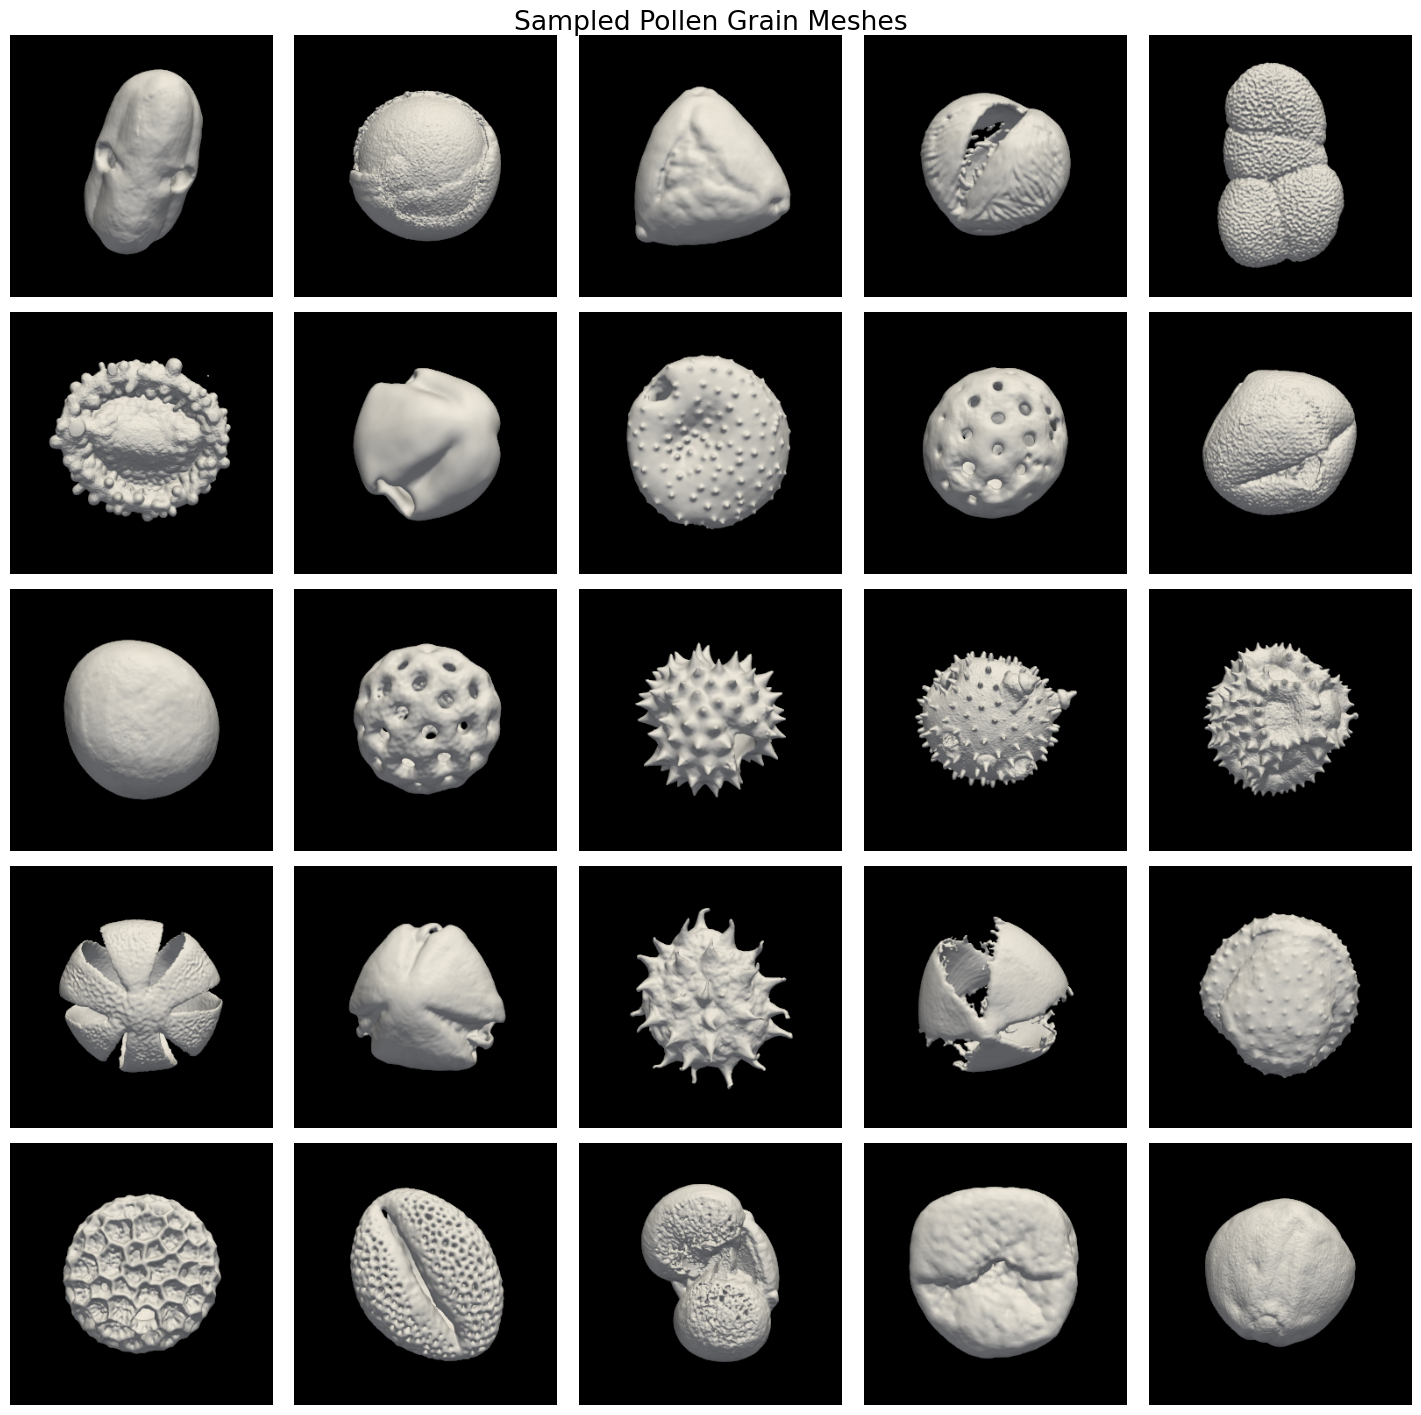

In [3]:
sample_size = 25
sampled_files = random.sample(stl_files, sample_size) if len(stl_files) >= sample_size else stl_files

screenshots = []
for file in sampled_files:
    file_path = os.path.join(RAW_MESHES_DIR, file)
    img = get_mesh_screenshot(file_path)
    if img is not None:
        screenshots.append(img)

# Adjust grid dimensions based on the number of valid screenshots
if len(screenshots) < 25:
    print(f"Only {len(screenshots)} valid meshes found. Adjusting grid layout accordingly.")
    n_rows = n_cols = int(len(screenshots) ** 0.5) or 1
else:
    n_rows, n_cols = 5, 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(screenshots):
        ax.imshow(screenshots[i])
    ax.axis("off")

plt.suptitle("Sampled Pollen Grain Meshes", fontsize=20)
plt.tight_layout()
plt.show()

In [4]:
def load_mesh(file_path):
    """
    Load an STL file and return a PyVista mesh object.
    
    Parameters:
        file_path (str): Path to the STL file.
    
    Returns:
        pv.PolyData: The loaded mesh.
    """
    mesh = pv.read(file_path)
    return mesh

def visualize_mesh(mesh, notebook=True):
    """
    Visualize the provided PyVista mesh.
    
    Parameters:
        mesh (pv.PolyData): The mesh to visualize.
        notebook (bool): Whether to render in a Jupyter notebook environment.
    """
    mesh.plot(notebook=notebook)


if stl_files:
    first_file_path = os.path.join(RAW_MESHES_DIR, stl_files[206])
    mesh_data = load_mesh(first_file_path)
    
    visualize_mesh(mesh_data, notebook=True)
else:
    print("No STL files found in the specified folder.")

# Experiment 2: Mesh Properties Analysis

In this section, we compute several key metrics for each mesh: -
**n_vertices**: Total number of vertices. - **n_faces**: Total number of
faces (cells). - **avg_edge_length**: Average length of the edges. -
**std_edge_length**: Standard deviation of edge lengths. -
**avg_normal_magnitude**: Average magnitude of point normals.

These metrics provide insight into the resolution and geometric
complexity of each mesh.

## Function Definitions

Functions are defined to load meshes, compute properties, and flag
outliers using the Interquartile Range (IQR) method.

In [5]:
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_mesh_properties(mesh):
    """
    Compute key properties of a mesh using vectorized operations.
    
    Assumes that the mesh is triangulated.
    
    Returns a dictionary with:
      - n_vertices: number of vertices in the mesh.
      - n_faces: number of faces (using n_cells).
      - avg_edge_length: mean length of all edges.
      - std_edge_length: standard deviation of the edge lengths.
      - avg_normal_magnitude: average magnitude of point normals (if available).
    """
    n_vertices = mesh.n_points
    n_faces = mesh.n_cells  # Using n_cells instead of deprecated n_faces

    pts = mesh.points

    try:
        faces = mesh.faces.reshape((-1, 4))[:, 1:4]
    except Exception as e:
        print("Error reshaping faces. Mesh may not be triangulated.")
        return None

    face_pts = pts[faces]

    edge1 = face_pts[:, 1] - face_pts[:, 0]
    edge2 = face_pts[:, 2] - face_pts[:, 1]
    edge3 = face_pts[:, 0] - face_pts[:, 2]

    lengths1 = np.linalg.norm(edge1, axis=1)
    lengths2 = np.linalg.norm(edge2, axis=1)
    lengths3 = np.linalg.norm(edge3, axis=1)

    all_lengths = np.concatenate([lengths1, lengths2, lengths3])
    avg_edge_length = np.mean(all_lengths)
    std_edge_length = np.std(all_lengths)

    if hasattr(mesh, 'point_normals') and mesh.point_normals is not None:
        normals = mesh.point_normals
        avg_normal_magnitude = np.mean(np.linalg.norm(normals, axis=1))
    else:
        avg_normal_magnitude = None

    return {
        'n_vertices': n_vertices,
        'n_faces': n_faces,
        'avg_edge_length': avg_edge_length,
        'std_edge_length': std_edge_length,
        'avg_normal_magnitude': avg_normal_magnitude
    }

def process_file(file_path):
    """
    Helper function to process a single file. Returns mesh properties.
    """
    try:
        mesh = pv.read(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    if mesh.n_points == 0:
        print(f"Skipping empty mesh: {file_path}")
        return None
    props = compute_mesh_properties(mesh)
    return props

def flag_outliers(values):
    """
    Identify outliers based on the IQR method and sort them by how much they deviate from the threshold.
    
    For each value outside the acceptable range, the deviation is measured as:
      - lower deviation: lower_bound - value, if the value is below lower_bound.
      - upper deviation: value - upper_bound, if the value is above upper_bound.
    
    Returns a list of tuples (index, deviation) sorted in descending order of deviation.
    """
    values = np.array(values)
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = []
    for i, v in enumerate(values):
        if v < lower_bound:
            deviation = lower_bound - v
            outliers.append((i, deviation))
        elif v > upper_bound:
            deviation = v - upper_bound
            outliers.append((i, deviation))
    # Sort outliers by deviation (largest deviation first)
    outliers_sorted = sorted(outliers, key=lambda x: x[1], reverse=True)
    return outliers_sorted

def analyze_dataset_properties(raw_meshes_dir):
    """
    Process all STL files in the specified directory in parallel using Joblib,
    compute mesh properties, print a summary of the mean and standard deviation
    for each property, and plot each metric on its own subplot with annotated bars.
    Returns the outlier indices for further inspection.
    """
    stl_files = [file for file in os.listdir(raw_meshes_dir) if file.endswith(".stl")]
    file_paths = [os.path.join(raw_meshes_dir, file) for file in stl_files]

    results = Parallel(n_jobs=-1)(
        delayed(process_file)(fp) for fp in tqdm(file_paths, desc="Processing meshes")
    )
    results = [r for r in results if r is not None]
    
    if not results:
        print("No valid meshes processed.")
        return

    # Collect each metric into separate lists
    vertices_list = [r['n_vertices'] for r in results]
    faces_list = [r['n_faces'] for r in results]
    edge_length_list = [r['avg_edge_length'] for r in results]
    edge_length_std_list = [r['std_edge_length'] for r in results]
    normal_mag_list = [r['avg_normal_magnitude'] for r in results if r['avg_normal_magnitude'] is not None]

    summary = {
        'n_vertices': (np.mean(vertices_list), np.std(vertices_list)),
        'n_faces': (np.mean(faces_list), np.std(faces_list)),
        'avg_edge_length': (np.mean(edge_length_list), np.std(edge_length_list)),
        'edge_length_std': (np.mean(edge_length_std_list), np.std(edge_length_std_list))
    }
    if normal_mag_list:
        summary['avg_normal_magnitude'] = (np.mean(normal_mag_list), np.std(normal_mag_list))
    
    print("\n--- Dataset Mesh Properties Summary (mean ± std) ---")
    for key, (mean_val, std_val) in summary.items():
        print(f" - {key}: {mean_val:.2f} ± {std_val:.2f}")
    
    # Compute outlier indices for each property (do not print them)
    outlier_indices = {}
    properties = {
        'n_vertices': vertices_list,
        'n_faces': faces_list,
        'avg_edge_length': edge_length_list,
        'edge_length_std': edge_length_std_list
    }
    if normal_mag_list:
        properties['avg_normal_magnitude'] = normal_mag_list

    for key, values in properties.items():
        sorted_outliers = flag_outliers(values)
        outlier_indices[key] = sorted_outliers
    
    return outlier_indices, {
    "vertices_list": vertices_list,
    "faces_list": faces_list,
    "edge_length_list": edge_length_list,
    "edge_length_std_list": edge_length_std_list,
    "normal_mag_list": normal_mag_list
    }

outliers, mesh_stats = analyze_dataset_properties(RAW_MESHES_DIR)

Processing meshes:   0%|          | 0/207 [00:00<?, ?it/s]Processing meshes:  31%|███       | 64/207 [00:00<00:00, 404.34it/s]Processing meshes:  62%|██████▏   | 128/207 [00:01<00:00, 91.28it/s]Processing meshes:  93%|█████████▎| 192/207 [00:03<00:00, 39.83it/s]Processing meshes: 100%|██████████| 207/207 [00:03<00:00, 52.74it/s]


--- Dataset Mesh Properties Summary (mean ± std) ---
 - n_vertices: 269226.55 ± 216488.00
 - n_faces: 538485.99 ± 432855.65
 - avg_edge_length: 0.21 ± 0.10
 - edge_length_std: 0.09 ± 0.03
 - avg_normal_magnitude: 1.00 ± 0.00

## Plotting Top Outlier Meshes

For further inspection, the top outliers based on the number of vertices
are visualized. This helps identify meshes that deviate significantly
from the norm.

In [6]:
def plot_top_outliers(metric_outliers, top_n=5, offset_distance=200.0, raw_meshes_dir=RAW_MESHES_DIR):
    """
    Plot the top_n outlier meshes for a given metric.
    
    Parameters:
        metric_outliers (list of tuples): Each tuple is (index, deviation).
        top_n (int): Number of outlier meshes to plot.
        offset_distance (float): Distance offset along the x-axis.
        raw_meshes_dir (str): Directory containing STL files.
    """
    stl_files = [file for file in os.listdir(raw_meshes_dir) if file.endswith(".stl")]
    
    top_outliers = metric_outliers[:top_n]
    print(f"--- Plotting top {len(top_outliers)} outliers ---")
    for i, (idx, deviation) in enumerate(top_outliers):
        print(f" - {idx}: {stl_files[idx]} (deviation: {deviation:.2f})")
    
    plotter = pv.Plotter()
    
    for i, (idx, deviation) in enumerate(top_outliers):
        file_path = os.path.join(raw_meshes_dir, stl_files[idx])
        try:
            mesh = pv.read(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
        
        offset = np.array([i * offset_distance, 0, 0])
        mesh.translate(offset, inplace=True)
        plotter.add_mesh(mesh, color='white', opacity=0.8)
    
    plotter.show()

# Plot the top 5 outliers based on n_vertices.
plot_top_outliers(outliers['n_vertices'], top_n=5)

--- Plotting top 5 outliers ---
 - 66: 17900_Germinating_lily_Lilium_sp_pollen_grain.stl (deviation: 1234488.00)
 - 55: 17846_Common_fern_Polypodium_vulgare_spore.stl (deviation: 424338.00)
 - 44: 17826_Blue_passion_flower_Passiflora_caerulea_pollen_grain.stl (deviation: 293871.00)
 - 119: 20939_Western_hemlock_Tsuga_heterophylla_pollen_grain.stl (deviation: 115916.00)
 - 87: 20611_Cuckoo_flower_Cardamine_pratensis_pollen_grain.stl (deviation: 86168.00)

# Experiment 3: Duplicate Mesh Detection

This experiment aims to identify potential duplicates or near-duplicates
by comparing normalized feature vectors derived from mesh properties.
The feature vector includes: - Number of vertices - Number of faces -
Average edge length - Standard deviation of edge lengths

A Euclidean distance is computed between normalized features, and meshes
with a distance below a set threshold are flagged as duplicates.

In [7]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

def detect_duplicate_meshes(raw_meshes_dir, threshold=0.05):
    """
    Detect duplicate meshes based on their normalized geometric properties.
    
    Parameters:
        raw_meshes_dir (str): Directory containing STL files.
        threshold (float): Euclidean distance threshold for duplicates.
    
    Returns:
        duplicates (dict): Dictionary mapping a filename to a list of duplicates.
    """
    stl_files = [file for file in os.listdir(raw_meshes_dir) if file.endswith(".stl")]
    file_paths = [os.path.join(raw_meshes_dir, file) for file in stl_files]
    
    results = Parallel(n_jobs=-1)(
        delayed(process_file)(fp) for fp in tqdm(file_paths, desc="Processing meshes for duplicates")
    )
    valid_indices = [i for i, r in enumerate(results) if r is not None]
    valid_files = [stl_files[i] for i in valid_indices]
    
    features = []
    for r in results:
        if r is not None:
            features.append([
                r['n_vertices'],
                r['n_faces'],
                r['avg_edge_length'],
                r['std_edge_length']
            ])
    features = np.array(features)
    
    scaler = StandardScaler()
    features_norm = scaler.fit_transform(features)
    dist_matrix = squareform(pdist(features_norm, metric='euclidean'))
    
    duplicates = {}
    n = len(valid_files)
    for i in range(n):
        dup_list = []
        for j in range(i + 1, n):
            if dist_matrix[i, j] < threshold:
                dup_list.append(valid_files[j])
        if dup_list:
            duplicates[valid_files[i]] = dup_list
    return duplicates

dups = detect_duplicate_meshes(RAW_MESHES_DIR, threshold=0.05)
print("Duplicate candidates found:")
for key, dup_list in dups.items():
    print(f"File: {key} duplicates: {dup_list}")

Processing meshes for duplicates:   0%|          | 0/207 [00:00<?, ?it/s]Processing meshes for duplicates:  31%|███       | 64/207 [00:00<00:00, 470.15it/s]Processing meshes for duplicates:  62%|██████▏   | 128/207 [00:00<00:00, 123.38it/s]Processing meshes for duplicates:  93%|█████████▎| 192/207 [00:03<00:00, 48.34it/s] Processing meshes for duplicates: 100%|██████████| 207/207 [00:03<00:00, 64.55it/s]

Duplicate candidates found:
File: 21256_German_knotweed_Scleranthus_annuus_pollen_grain_shrunken.stl duplicates: ['21271_White_campion_Silene_alba_pollen_grain_shrunken.stl']
File: 21264_European_goldenrod_Solidago_virgaurea_pollen_grain.stl duplicates: ['21266_Field_madder_Sherardia_arvensis_pollen_grain.stl']
File: 21376_Red_fescue_Festuca_rubra_pollen_grain_shrunken.stl duplicates: ['21377_Red_fescue_Festuca_rubra_pollen_grain_shrunken.stl']
File: 21378_Hemp-agrimony_Eupatorium_cannabinum_pollen_grain_shrunken.stl duplicates: ['21379_Hemp-agrimony_Eupatorium_cannabinum_pollen_grain_shrunken.stl']

# Experiment 4: Mesh Quality Analysis

### General Idea

-   Meshes with unusually high `std_edge_length` often contain sharp
    artifacts or disconnected regions.
-   Very low `n_vertices` and `n_faces` may indicate overly simplified
    or corrupted models.
-   Low `avg_normal_magnitude` values often suggest noisy or flat
    regions, potentially due to flattening or scanning artifacts.

In [8]:
# Experiment 4: Mesh Quality Analysis – Visualizing Typical Defects

# Visualize meshes with very high edge length std (irregular surfaces)
print("Visualizing top meshes with high standard deviation of edge lengths:")
plot_top_outliers(outliers['edge_length_std'], top_n=5)

# Visualize meshes with very low vertex count (over-simplified or broken)
# Sort in ascending order to get those with lowest n_vertices
lowest_vertices = sorted(outliers['n_vertices'], key=lambda x: x[1], reverse=True)[-5:]
print("\nVisualizing meshes with very low vertex counts:")
plot_top_outliers(lowest_vertices, top_n=5)

# Visualize meshes with low normal magnitude (noisy or flattened shapes), if normals are available
if 'avg_normal_magnitude' in outliers:
    print("\nVisualizing meshes with low average normal magnitude:")
    low_normal_mags = sorted(outliers['avg_normal_magnitude'], key=lambda x: x[1], reverse=True)[-5:]
    plot_top_outliers(low_normal_mags, top_n=5)
else:
    print("\nNo valid normal vectors available for avg_normal_magnitude analysis.")

Visualizing top meshes with high standard deviation of edge lengths:
--- Plotting top 5 outliers ---
 - 12: 17787_Yellow_iris_Iris_pseudacorus_pollen_grain.stl (deviation: 0.30)
 - 57: 17879_Pumpkin_Cucurbita_pepo_pollen_grain.stl (deviation: 0.04)
 - 10: 17785_Hedge_bindweed_Calystegia_sepium_pollen_grain.stl (deviation: 0.04)
 - 21: 17796_Hardy_fuchsia_Fuchsia_magellanica_pollen_grain.stl (deviation: 0.02)
 - 81: 20605_Field_maple_Acer_campestre_pollen_grain.stl (deviation: 0.02)


Visualizing meshes with very low vertex counts:
--- Plotting top 5 outliers ---
 - 64: 17886_Common_wheat_Triticum_aestivan_pollen_grain.stl (deviation: 59653.00)
 - 50: 17833_European_white_water_lily_Nymphaea_alba_pollen_grain.stl (deviation: 29662.00)
 - 57: 17879_Pumpkin_Cucurbita_pepo_pollen_grain.stl (deviation: 27549.00)
 - 61: 17883_Evening_primrose_Oenothera_fruticosa_pollen_grain.stl (deviation: 20212.00)
 - 148: 21252_Pontic_rhododendron_Rhododendron_ponticum_pollen_grain.stl (deviation: 7516.00)


Visualizing meshes with low average normal magnitude:
--- Plotting top 5 outliers ---
 - 162: 21271_White_campion_Silene_alba_pollen_grain_shrunken.stl (deviation: 0.00)
 - 117: 20937_Small-leaved_lime_Tilia_cordata_pollen_grain.stl (deviation: 0.00)
 - 119: 20939_Western_hemlock_Tsuga_heterophylla_pollen_grain.stl (deviation: 0.00)
 - 116: 20936_Field_pennycress_Thlaspi_arvense_pollen_grain_2.stl (deviation: 0.00)
 - 138: 21145_Pine_Pinus_sp_pollen_grain.stl (deviation: 0.00)

# Experiment 5: Surface Smoothness and Roughness

To further characterize the mesh geometry, we compute surface
**curvature-based metrics** to quantify whether a pollen grain appears
smooth (e.g., spherical, elliptical) or rough (e.g., with spikes or
ridges).

We use **mean curvature** as a proxy: - Low curvature → smooth, flat or
rounded surfaces - High curvature → sharp features or fine details
(e.g., spikes)

This experiment helps categorize the dataset into morphological classes
relevant for classification and reconstruction.

We visualize histograms of curvature distributions and sample meshes
from both ends of the spectrum.

In [9]:
def compute_curvature_metrics(mesh):
    """
    Compute curvature-based metrics from a mesh surface.
    
    Returns:
        mean_curv: Mean of mean curvature values
        std_curv: Standard deviation (roughness indicator)
    """
    try:
        curvatures = mesh.curvature(curv_type='mean')
    except Exception as e:
        print("Curvature computation failed:", e)
        return None

    mean_curv = np.mean(np.abs(curvatures))  # take abs to avoid cancellation
    std_curv = np.std(curvatures)

    return mean_curv, std_curv

In [10]:
curvature_results = []
curved_file_paths = []

for file in tqdm(stl_files, desc="Computing curvature metrics"):
    file_path = os.path.join(RAW_MESHES_DIR, file)
    try:
        mesh = pv.read(file_path)
        if mesh.n_points == 0:
            continue
        m, s = compute_curvature_metrics(mesh)
        if m is not None:
            curvature_results.append((m, s))
            curved_file_paths.append(file_path)
    except Exception as e:
        print("Error:", e)

mean_curvs, std_curvs = zip(*curvature_results)

Computing curvature metrics:   0%|          | 0/207 [00:00<?, ?it/s]Computing curvature metrics:   1%|          | 2/207 [00:00<00:12, 16.15it/s]Computing curvature metrics:   2%|▏         | 4/207 [00:00<00:14, 13.99it/s]Computing curvature metrics:   3%|▎         | 6/207 [00:00<00:14, 13.51it/s]Computing curvature metrics:   4%|▍         | 8/207 [00:00<00:14, 13.46it/s]Computing curvature metrics:   5%|▍         | 10/207 [00:00<00:14, 13.76it/s]Computing curvature metrics:   6%|▌         | 12/207 [00:00<00:14, 13.37it/s]Computing curvature metrics:   7%|▋         | 14/207 [00:01<00:14, 13.20it/s]Computing curvature metrics:   8%|▊         | 16/207 [00:01<00:14, 13.13it/s]Computing curvature metrics:   9%|▊         | 18/207 [00:01<00:14, 12.85it/s]Computing curvature metrics:  10%|▉         | 20/207 [00:01<00:14, 13.03it/s]Computing curvature metrics:  11%|█         | 22/207 [00:01<00:14, 12.59it/s]Computing curvature metrics:  12%|█▏        | 24/207 [00:01<00:14, 12.51it/s]Computing cu

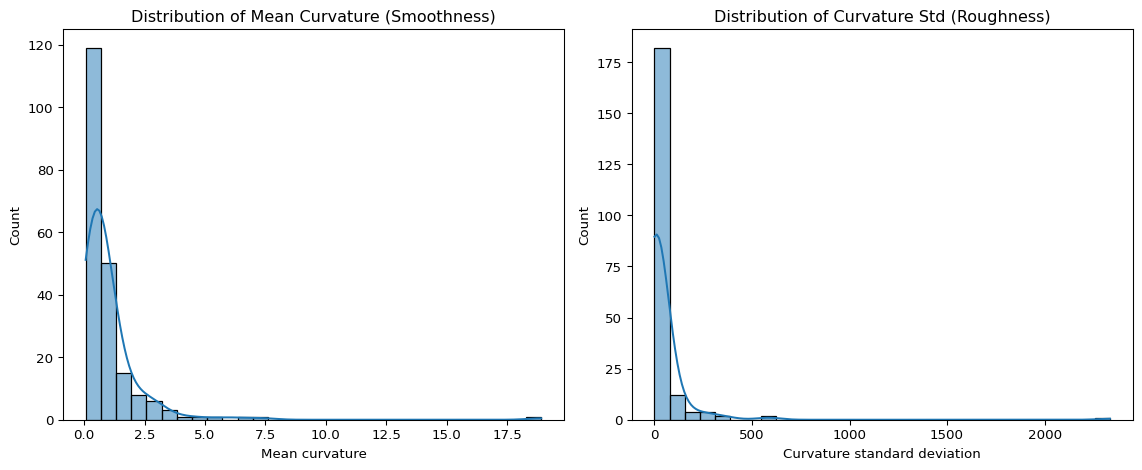

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(mean_curvs, bins=30, kde=True)
plt.title("Distribution of Mean Curvature (Smoothness)")
plt.xlabel("Mean curvature")

plt.subplot(1, 2, 2)
sns.histplot(std_curvs, bins=30, kde=True)
plt.title("Distribution of Curvature Std (Roughness)")
plt.xlabel("Curvature standard deviation")

plt.tight_layout()
plt.show()

In [12]:
# Top 3 smoothest and roughest meshes
smoothest = np.argsort(mean_curvs)[:3]
roughest = np.argsort(std_curvs)[-3:]

def show_mesh_group(indices, title):
    plotter = pv.Plotter(shape=(1, len(indices)))
    for i, idx in enumerate(indices):
        mesh = pv.read(curved_file_paths[idx])
        plotter.subplot(0, i)
        plotter.add_mesh(mesh, color="white")
        plotter.camera_position = 'xy'
    plotter.show(title=title)

show_mesh_group(smoothest, "Smoothest Meshes (Low Mean Curvature)")
show_mesh_group(roughest, "Roughest Meshes (High Curvature Std)")

# Experiment 6: Shape Classification – Spherical vs. Non-Spherical Pollen Grains

## General Idea

In this experiment, we classify each pollen mesh based on its geometric
shape using the axis ratios of its bounding box. We aim to distinguish
between general classes such as:

-   **Spherical** – nearly equal extent in all dimensions
-   **Ellipsoidal** – one dominant axis, but still compact
-   **Elongated / Rod-like** – one axis significantly longer
-   **Flattened / Disc-like** – one axis significantly shorter
-   **Irregular** – no clear symmetry

These shape classes are helpful for morphological categorization,
clustering, and potentially guiding reconstruction models.

The classification is based on the ratios of the bounding box dimensions
(X, Y, Z), normalized by the largest dimension.

In [13]:
def classify_shape(mesh, tolerance=0.15):
    """
    Classify mesh into simple geometric shape based on bounding box dimensions.
    
    Returns:
        str: one of ['spherical', 'ellipsoidal', 'elongated', 'flattened', 'irregular']
    """
    bounds = mesh.bounds  # (xmin, xmax, ymin, ymax, zmin, zmax)
    dims = np.array([
        bounds[1] - bounds[0],
        bounds[3] - bounds[2],
        bounds[5] - bounds[4],
    ])
    dims_sorted = np.sort(dims)
    ratios = dims_sorted / np.max(dims_sorted)

    # Heuristics:
    if np.all(np.abs(ratios - 1.0) < tolerance):
        return "spherical"
    elif ratios[2] > 0.8 and ratios[0] > 0.6:
        return "ellipsoidal"
    elif ratios[2] > 0.9 and ratios[0] < 0.5:
        return "elongated"
    elif ratios[0] < 0.3 and ratios[2] < 0.8:
        return "flattened"
    else:
        return "irregular"

In [14]:
shape_labels = []
shape_file_paths = []

for file in tqdm(stl_files, desc="Classifying mesh shapes"):
    file_path = os.path.join(RAW_MESHES_DIR, file)
    try:
        mesh = pv.read(file_path)
        if mesh.n_points == 0:
            continue
        shape = classify_shape(mesh)
        shape_labels.append(shape)
        shape_file_paths.append(file_path)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

Classifying mesh shapes:   0%|          | 0/207 [00:00<?, ?it/s]Classifying mesh shapes:   2%|▏         | 4/207 [00:00<00:06, 30.46it/s]Classifying mesh shapes:   4%|▍         | 8/207 [00:00<00:06, 30.25it/s]Classifying mesh shapes:   6%|▌         | 12/207 [00:00<00:06, 29.94it/s]Classifying mesh shapes:   7%|▋         | 15/207 [00:00<00:06, 29.74it/s]Classifying mesh shapes:   9%|▊         | 18/207 [00:00<00:06, 28.62it/s]Classifying mesh shapes:  10%|█         | 21/207 [00:00<00:06, 28.03it/s]Classifying mesh shapes:  12%|█▏        | 24/207 [00:00<00:06, 26.54it/s]Classifying mesh shapes:  13%|█▎        | 27/207 [00:01<00:08, 21.90it/s]Classifying mesh shapes:  14%|█▍        | 30/207 [00:01<00:08, 21.00it/s]Classifying mesh shapes:  16%|█▌        | 33/207 [00:01<00:11, 15.57it/s]Classifying mesh shapes:  17%|█▋        | 35/207 [00:01<00:13, 12.97it/s]Classifying mesh shapes:  18%|█▊        | 37/207 [00:02<00:15, 10.65it/s]Classifying mesh shapes:  19%|█▉        | 39/207 [00:02<00:16,

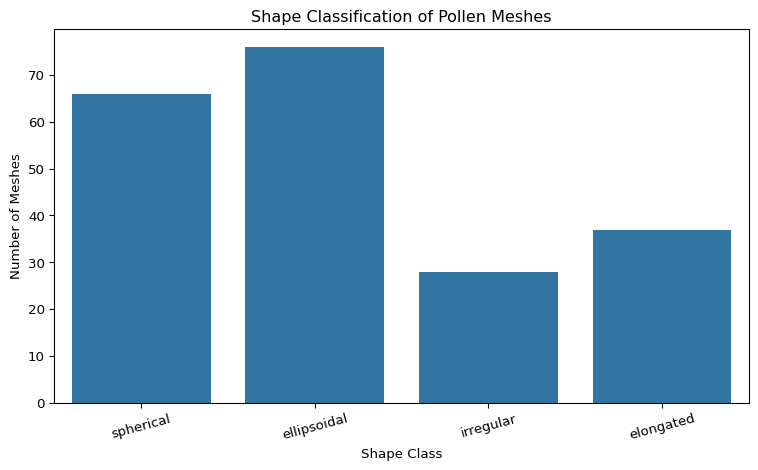

In [15]:
from collections import Counter

shape_counts = Counter(shape_labels)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(shape_counts.keys()), y=list(shape_counts.values()))
plt.title("Shape Classification of Pollen Meshes")
plt.ylabel("Number of Meshes")
plt.xlabel("Shape Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [16]:
def show_examples_for_shape(shape_name, n=3):
    matching = [fp for fp, lbl in zip(shape_file_paths, shape_labels) if lbl == shape_name]
    if not matching:
        print(f"No examples found for shape: {shape_name}")
        return
    sample = matching[:n]
    plotter = pv.Plotter(shape=(1, len(sample)))
    for i, path in enumerate(sample):
        mesh = pv.read(path)
        plotter.subplot(0, i)
        plotter.add_mesh(mesh, color="white")
    # Setze Kameraeinstellung nur einmal, falls das für alle Subplots gelten soll
    plotter.camera_position = 'xy'
    plotter.show(title=f"Examples of {shape_name} pollen")

# Show examples for a few shapes
for shape in ["spherical", "ellipsoidal", "elongated", "flattened", "irregular"]:
    show_examples_for_shape(shape)

No examples found for shape: flattened

# Mesh Statistics and Summary

## Table Summary

In [17]:
import pandas as pd

metrics = ["n_vertices", "n_faces", "avg_edge_length", "std_edge_length"]
mean_vals = [
    np.mean(mesh_stats["vertices_list"]),
    np.mean(mesh_stats["faces_list"]),
    np.mean(mesh_stats["edge_length_list"]),
    np.mean(mesh_stats["edge_length_std_list"]),
]
std_vals = [
    np.std(mesh_stats["vertices_list"]),
    np.std(mesh_stats["faces_list"]),
    np.std(mesh_stats["edge_length_list"]),
    np.std(mesh_stats["edge_length_std_list"]),
]

if mesh_stats["normal_mag_list"]:
    metrics.append("avg_normal_magnitude")
    mean_vals.append(np.mean(mesh_stats["normal_mag_list"]))
    std_vals.append(np.std(mesh_stats["normal_mag_list"]))

summary_df = pd.DataFrame({
    "Metric": metrics,
    "Mean": mean_vals,
    "Std Dev": std_vals
})

summary_df.style.format({"Mean": "{:.2f}", "Std Dev": "{:.2f}"})

# Results and Discussion

The experiments reveal the following key findings:

-   **Visualization:** A random sample of meshes was rendered,
    confirming that most STL files contain valid geometries suitable for
    further analysis.
-   **Mesh Properties:** Summary statistics indicate variations in
    vertex and face counts. The computed average edge lengths and their
    deviations provide insight into mesh resolution and potential
    irregularities.
-   **Outlier Detection:** Outliers based on vertex count and other
    metrics were identified, which may correspond to damaged or overly
    simplified meshes.
-   **Duplicate Detection:** Using normalized geometric features,
    several candidate duplicate meshes were flagged, suggesting
    potential redundancies in the dataset.
-   **Extended Analysis:** Additional properties (when available)
    further confirmed the overall consistency of the dataset while
    highlighting specific cases for further investigation.

# Findings and further steps of the analysis for the preprocessing pipeline

-   todo: explain what all the results are and how we can use them to
    improve the preprocessing pipeline

# Conclusion

This exploratory analysis of raw 3D meshes has provided a comprehensive
overview of mesh quality, consistency, and potential anomalies. The
combined visualization, property computation, and duplicate detection
techniques offer a robust framework for preliminary data quality
assessment. Future work may focus on refining these metrics and
incorporating additional geometric and topological analyses for improved
mesh validation and processing.

------------------------------------------------------------------------

This document can be rendered directly using Quarto, providing both the
code and a detailed narrative suitable for a scientific publication or
internal report.